# State of the vaccine

In this notebook, I analyse the current state of vaccination in India, providing charts and informatics to show how far we are and how far we are yet to go. I also provide a predictive analysis of the vaccine trends till June 20.

## Reading and cleaning up the data

We'll be using the [COVID 19 India](https://www.covid19india.org) API for this analysis. I start by importing the usual libraries required, and loading in the vaccine data.

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import geopandas
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.arima_model import ARIMA

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
vaccine_data = pd.read_csv("https://api.covid19india.org/csv/latest/cowin_vaccine_data_statewise.csv")
vaccine_data['Updated On'] = pd.to_datetime(vaccine_data['Updated On'], format="%d/%m/%Y")

In [3]:
vaccine_data.head(5)

,Updated On,State,Total Individuals Vaccinated,Total Sessions Conducted,Total Sites,First Dose Administered,Second Dose Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Covaxin Administered,Total CoviShield Administered,Total Sputnik V Administered,AEFI,18-45 years (Age),45-60 years (Age),60+ years (Age),Total Doses Administered
0,2021-01-16,India,48276.0,3455.0,2957.0,48276.0,0.0,23757.0,24517.0,2.0,579.0,47697.0,NaN,NaN,NaN,NaN,NaN,48276.0
1,2021-01-17,India,58604.0,8532.0,4954.0,58604.0,0.0,27348.0,31252.0,4.0,635.0,57969.0,NaN,NaN,NaN,NaN,NaN,58604.0
2,2021-01-18,India,99449.0,13611.0,6583.0,99449.0,0.0,41361.0,58083.0,5.0,1299.0,98150.0,NaN,NaN,NaN,NaN,NaN,99449.0
3,2021-01-19,India,195525.0,17855.0,7951.0,195525.0,0.0,81901.0,113613.0,11.0,3017.0,192508.0,NaN,NaN,NaN,NaN,NaN,195525.0
4,2021-01-20,India,251280.0,25472.0,10504.0,251280.0,0.0,98111.0,153145.0,24.0,3946.0,247334.0,NaN,NaN,NaN,NaN,NaN,251280.0


Now that the vaccine data is loaded, since I'll be mapping the vaccine data on a map for a statewise analysis, we need some shapefiles. I've taken the shapefiles from [Anuj Tiwari's repo](https://github.com/AnujTiwari/India-State-and-Country-Shapefile-Updated-Jan-2020), and changed a few of the state names so that they match up with the state names in `vaccine_data`.

In [4]:
india_map = geopandas.read_file("India-State-and-Country-Shapefile-Updated-Jan-2020/India_State_Boundary.shp")
india_map.loc[india_map['State_Name']=='Chhattishgarh','State_Name'] = "Chhattisgarh"
india_map.loc[india_map['State_Name']=='Daman and Diu and Dadra and Nagar Haveli','State_Name'] = "Dadra and Nagar Haveli and Daman and Diu"
india_map.loc[india_map['State_Name']=='Andaman & Nicobar','State_Name'] = "Andaman and Nicobar Islands"
india_map.loc[india_map['State_Name']=='Tamilnadu','State_Name'] = "Tamil Nadu"
india_map.loc[india_map['State_Name']=='Telengana','State_Name'] = "Telangana"
india_map.head()

,State_Name,geometry
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((10341718.474 1449533.161, 1034..."
1,Chandigarh,"POLYGON ((8546255.616 3606050.813, 8546315.400..."
2,Dadra and Nagar Haveli and Daman and Diu,"MULTIPOLYGON (((8122247.822 2312434.407, 81223..."
3,Delhi,"POLYGON ((8583390.570 3359116.190, 8583476.212..."
4,Haryana,"POLYGON ((8524318.539 3516490.865, 8524451.392..."


Now that we've loaded the shapefiles, let's start with a statewise analysis. We aim to show how immunised each state is against COVID. We get the present state of vaccination from the last day, and store that in `present_state`

In [5]:
present_state = vaccine_data.loc[vaccine_data['Updated On']==pd.to_datetime('13/06/2021')]
present_state.head()

,Updated On,State,Total Individuals Vaccinated,Total Sessions Conducted,Total Sites,First Dose Administered,Second Dose Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Covaxin Administered,Total CoviShield Administered,Total Sputnik V Administered,AEFI,18-45 years (Age),45-60 years (Age),60+ years (Age),Total Doses Administered
148,2021-06-13,India,203705131.0,7549518.0,22768.0,203705131.0,46951231.0,109979462.0,93690273.0,35396.0,30185294.0,220445754.0,25314.0,22082.0,58561036.0,81756122.0,63296269.0,250656362.0
302,2021-06-13,Andaman and Nicobar Islands,115711.0,50.0,1.0,115711.0,15352.0,62237.0,53465.0,9.0,0.0,131063.0,0.0,3.0,23843.0,61079.0,30785.0,131063.0
456,2021-06-13,Andhra Pradesh,9335665.0,261233.0,618.0,9335665.0,2622966.0,4578882.0,4755307.0,1476.0,2106717.0,9847536.0,4378.0,331.0,1693941.0,4740134.0,2899800.0,11958631.0
610,2021-06-13,Arunachal Pradesh,335606.0,13185.0,76.0,335606.0,79042.0,184587.0,150906.0,113.0,0.0,414648.0,0.0,272.0,151236.0,132877.0,51437.0,414648.0
764,2021-06-13,Assam,3883727.0,120011.0,563.0,3883727.0,928222.0,2104652.0,1778433.0,642.0,923873.0,3888076.0,0.0,194.0,1306428.0,1705312.0,871565.0,4811949.0


The final piece of data I'll use is the population pyramid of India; this will be useful in seeing how well immunized the population of India is age wise.

In [6]:
pop_pyramid = pd.read_csv("India-2021.csv")
pop_pyramid['T'] = pop_pyramid['M'] + pop_pyramid['F'] 
pop_pyramid.head()

,Age LB,Age UB,M,F,T
0,0,4,61705157,56100408,117805565
1,5,9,61156249,55470476,116626725
2,10,14,65529162,59247144,124776306
3,15,19,66720827,59535435,126256262
4,20,24,65190651,57919863,123110514


## Plotting the data: geographic, time and age analysis

Now that we have all the data, we're ready to start plotting some charts: associate the states with the states on the map, and then plot the map with matplotlib.

In [7]:
merged_map = india_map.set_index('State_Name').join(present_state.set_index('State'))

Text(0.3, 0.912, '(As of 13th June 2021)')

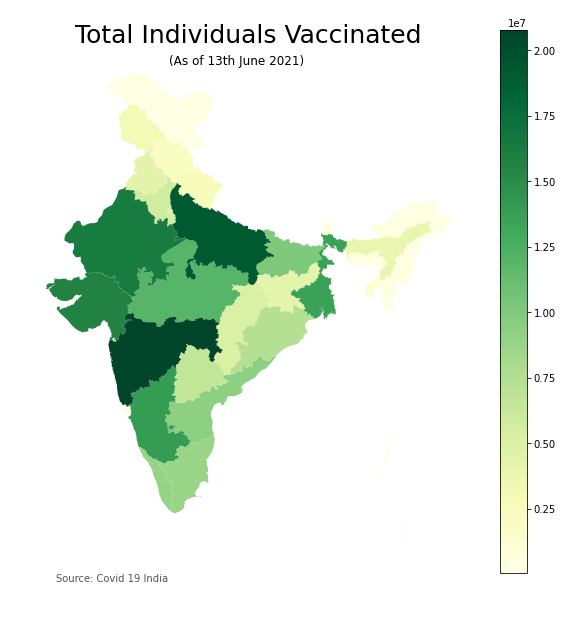

In [8]:
fig, ax = plt.subplots(1,figsize=(10,10))
merged_map.plot(column='Total Individuals Vaccinated', cmap='YlGn', ax=ax, legend=True)
ax.set_title('Total Individuals Vaccinated', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')
ax.annotate('Source: Covid 19 India',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')
ax.annotate('(As of 13th June 2021)',xy=(0.3, .912), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12)

The map resembles the GDP of the states themselves. This is intuitive, as so far the procurement policy followed by the government was to let 25% of the vaccines be procured by the states, 50% by the centre and 25% by the private sector. The private sector would naturally be concentrated in regions of higher GDP, and as a result we see the inequality in vaccination, where the richer states have a higher distribution of vaccine and the poorer ones don't. 

<left><img src="GDP_of_Indian_states_2020.png" width="40%"></left>

Now that we've analysed the data geographically, a time analysis would help. This also ties in nicely to the next section, where we'll predict how the vaccination schedule looks like. For a time analysis, we plot the data against the dates. 

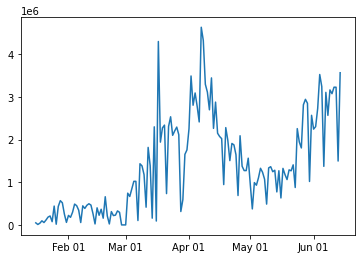

In [9]:
df = matplotlib.dates.DateFormatter("%b %d")
vaccine_data['Daily Individuals Vaccinated'] = vaccine_data.loc[vaccine_data['State']=='India', 'Total Individuals Vaccinated'].diff().fillna(vaccine_data['Total Individuals Vaccinated'])
plot_data = vaccine_data.loc[vaccine_data['State']=='India', ['Daily Individuals Vaccinated','Updated On']]
plot_data['Updated On'] = matplotlib.dates.date2num(plot_data['Updated On'])

plt.plot_date(plot_data['Updated On'], plot_data['Daily Individuals Vaccinated'], '-')
plt.gca().xaxis.set_major_formatter(df)

This is messy, because [even though vaccines are given on sundays](https://www.indiatoday.in/coronavirus-outbreak/story/coronavirus-covid-vaccine-april-all-days-week-holidays-1785997-2021-04-01), people seem reluctant to receive them on sundays as evidenced by the periodic dips. A better metric would be the seven day moving average, so let's plot that instead of raw data.

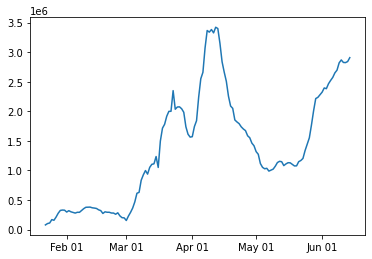

In [10]:
df = matplotlib.dates.DateFormatter("%b %d")
avg = plot_data.rolling(window=7)['Daily Individuals Vaccinated'].mean()
plt.plot_date(plot_data['Updated On'], avg, '-')
plt.gca().xaxis.set_major_formatter(df)

we can do the same for a few states to get a better feel of how the states are coping. Let's analyse the larger states: Maharashtra, Tamil Nadu and Uttar Pradesh

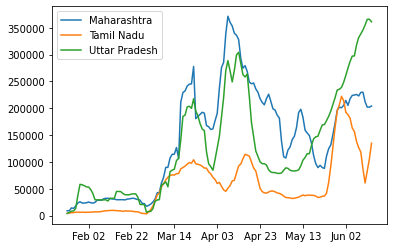

In [11]:
for state in vaccine_data['State'].unique():
    if state in ["Maharashtra", "Tamil Nadu", "Uttar Pradesh"]:
        state_vax = vaccine_data.loc[vaccine_data['State']==state, ['Total Individuals Vaccinated','Updated On']]
        state_vax['Total Individuals Vaccinated'] = state_vax['Total Individuals Vaccinated'].diff().rolling(window=7).mean()
        state_vax['Updated On'] = matplotlib.dates.date2num(state_vax['Updated On'])

        plt.plot(state_vax['Updated On'], state_vax['Total Individuals Vaccinated'], label=state)
        plt.gca().xaxis.set_major_formatter(df)
        plt.legend()


Finally, I'll do the age wise analysis. comparing the present state with the population pyramid would give us an idea of how many people are vaccinated per age group. Since the vaccine data is less granular than the population pyramid, I'll only be able to tell how well immunized the groups 18-45, 45-60 and 60+ are as a whole. 

[Text(0, 0, '18-45'), Text(1, 0, '45-60'), Text(2, 0, '60+')]

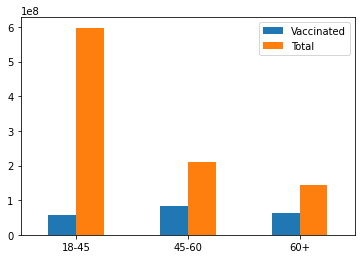

In [12]:
# Notice the 46 million added at the end: that's to account for people aged 18 & 19 (taken from Wikipedia's india pop pyramid)
n_1845 = sum(pop_pyramid.loc[(pop_pyramid['Age LB'] >= 20) & (pop_pyramid['Age UB'] < 45)]['T']) + 46000000
n_4560 = sum(pop_pyramid.loc[(pop_pyramid['Age LB'] >= 45) & (pop_pyramid['Age UB'] < 60)]['T'])
n_60p = sum(pop_pyramid.loc[(pop_pyramid['Age LB'] >= 60)]['T'])
age_data = [
    ['18-45', present_state.loc[present_state['State']=='India','18-45 years (Age)'].values[0], n_1845],
    ['45-60', present_state.loc[present_state['State']=='India','45-60 years (Age)'].values[0], n_4560],
    ['60+', present_state.loc[present_state['State']=='India','60+ years (Age)'].values[0], n_60p]
]

age_df = pd.DataFrame(age_data, columns=['Age','Vaccinated','Total'])

age_plot = age_df.plot(kind='bar', rot=0)
age_plot.set_xticklabels(age_df['Age'])

The immunization is almost uniform across age groups, even though the 18-45 age group was vaccinated from a later duration. _The proportion of people vaccinated to the total is what makes a difference_: the most vulnerable age groups are much better immunized as a percentage of total population of those groups.

## Predictive model

The general strategy for making a predictive model is to create a SLR (simple linear regression) model with multiple dependent parameters. However, in this case, I could not find datasets for the parameters that reasonably influence the vaccination schedule. Neither could I directly find information about how many people are booked for vaccination in the upcoming days. 

Making a mathematical model is the first approach I tried: the factors that vaccine distribution depends on are:
1. Number of vaccines produced
2. Number of people who register for obtaining a vaccine
since (2) >> (1), 1 acts as the bottleneck here. Obtaining concrete figures on the number of vaccines produced is very difficult, and predicting it depends on various factors such as raw materials, production line efficiency, how quickly vaccines are distributed etc. Hence, I didn't go the mathematical model way for this.

Since the duration for which we have to predict vaccines is small, we use the ARIMA (AutoRegressive Integrated Moving Average) model here to make predictions. We need to find the order of this model i.e. the number of differentials after which the process acts like a stationary process. The first difference of the daily covid cases looks like a stationary process:

<AxesSubplot:>

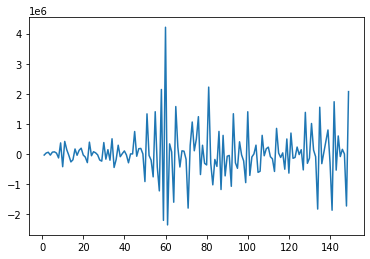

In [13]:
india_vax = vaccine_data.loc[vaccine_data['State']=='India', ['Total Individuals Vaccinated','Daily Individuals Vaccinated','Updated On']]
india_vax['Daily Individuals Vaccinated'].diff().plot()

The mean of this process is constant around 0, and the processses seem random. To see just how stationary it is, we can use an autocorrelation plot.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

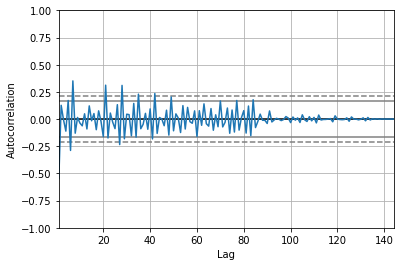

In [14]:
autocorrelation_plot(india_vax['Daily Individuals Vaccinated'].diff()[3:147])

From the autocorrelation graph, we see that the series is almost stationary after the 84th term. We shall use these terms to make our ARIMA model. To choose the parameters, we use the first difference of daily individuals vaccinated, and set a dependence on 7 previous terms (as seen previously, sundays dip, hence we need a weekly dependence at least)

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was

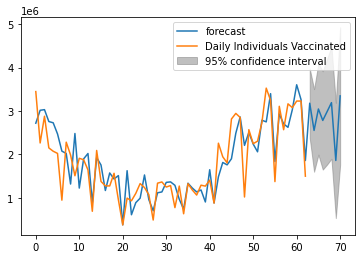

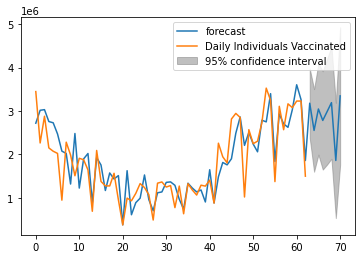

In [15]:
india_vax['Updated On'] = matplotlib.dates.date2num(india_vax['Updated On'])

model = ARIMA(india_vax['Daily Individuals Vaccinated'][85:149], order=(7,1,0))
model_fit = model.fit()
# summary of fit model
model_fit.plot_predict(1,156-85)
# 156 would be Mon, Jun 21  (149 is jun 14)

This model nicely predicts how the daily number of vaccines would look like over the next few days from June 13. Note the sharp dip at 69 (which corresponds to Sunday June 20, predicting a dip in vaccination on that day).  